# GradCAMによる可視化
## 以下のリンクに記載されているGrad_CAMの実装を試す。
## https://www.noconote.work/entry/2019/01/12/231723

In [1]:
# モジュールのインポート
%matplotlib inline
import urllib
import pickle
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms
#from torchvision import models
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from pathlib import Path
from IPython.core.debugger import Pdb

# 自作関数
import models
from utils import load_model
from dataset import TrainDataset, TTADataset, get_ids, N_CLASSES, DATA_ROOT

In [82]:
# モデルの読み込み (網膜コンペ)
apotos = True
if apotos:
    model = "resnet50"
    pretrained = True
    run_root = Path("Rockman_aug_CircleCrop/Rockman_aug_CircleCrop_0")

    model = getattr(models, "resnet50")(
        num_classes=N_CLASSES, pretrained=pretrained)

   # model = model.cuda()
    load_model(model, run_root / 'best-model.pt') 

Loaded model from epoch 16, step 645


In [83]:
# GradCamを実装
class GradCam:
    def __init__(self, model):
        self.model = model.eval()
        self.feature = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def __call__(self, x):
        image_size = (x.size(-1), x.size(-2))
        feature_maps = []
        
        for i in range(x.size(0)):
            img = x[i].data.cpu().numpy()
            img = img - np.min(img)
            if np.max(img) != 0:
                img = img / np.max(img)

            feature = x[i].unsqueeze(0)
            
            for ind,(name, module) in enumerate(model.net.named_children()):
               # print(name)
                if name == "avgpool":
                    avgpool_ind = ind
                    
          #  feature_ind = avgpool_ind - 1
            
            feature_module = nn.Sequential(*list(model.net.children())[:avgpool_ind]).eval() 
            
            for name, module in self.model.net.named_children():
              #  print(name)
                if name == "fc": # 最終の分類層
                    feature = feature.view(feature.size(0), -1)
                    feature = module(feature)
                    
                if name == "avgpool":
                    # 特徴抽出層から特徴を抽出
                 #   Pdb().set_trace()
                    feature = feature_module(feature)
                    feature.register_hook(self.save_gradient)
                    self.feature = feature
                   # post_avg_pool = 1
                    feature = module(feature)
                        
           # Pdb().set_trace()
            classes = F.sigmoid(feature)
            one_hot, _ = classes.max(dim=-1)
            self.model.zero_grad()
            one_hot.backward()

            weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
            
            mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
            mask = cv2.resize(mask.data.cpu().numpy(), image_size)
            mask = mask - np.min(mask)
            
            if np.max(mask) != 0:
                mask = mask / np.max(mask)
                
            feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
            cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
            cam = cam - np.min(cam)
            
            if np.max(cam) != 0:
                cam = cam / np.max(cam)
                
            feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))
            
        feature_maps = torch.stack(feature_maps)
        
        return feature_maps

image size:  (288, 288)


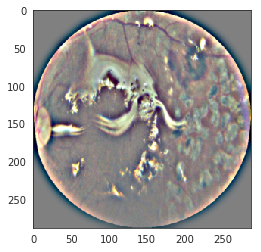

In [104]:
# 入力画像の読み込み
# TODO : IMG_SIZEをtransformから読み込めるようにする

IMG_SIZE = 288

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

test_image = Image.open("../images/_debug.png")
test_image_tensor = (transform((test_image))).unsqueeze(dim=0)

image_size = test_image.size
print("image size: ", image_size)

plt.imshow(test_image)

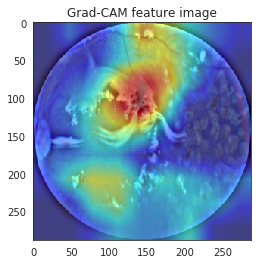

In [84]:
#grad_cam = GradCam(model)
grad_cam = GradCam(model)

feature_image = grad_cam(test_image_tensor).squeeze(dim=0)
feature_image = transforms.ToPILImage()(feature_image)

pred_idx = model(test_image_tensor).max(1)[1]
#print("pred: ", labels[int(pred_idx)])
plt.title("Grad-CAM feature image")
plt.imshow(feature_image.resize(image_size))


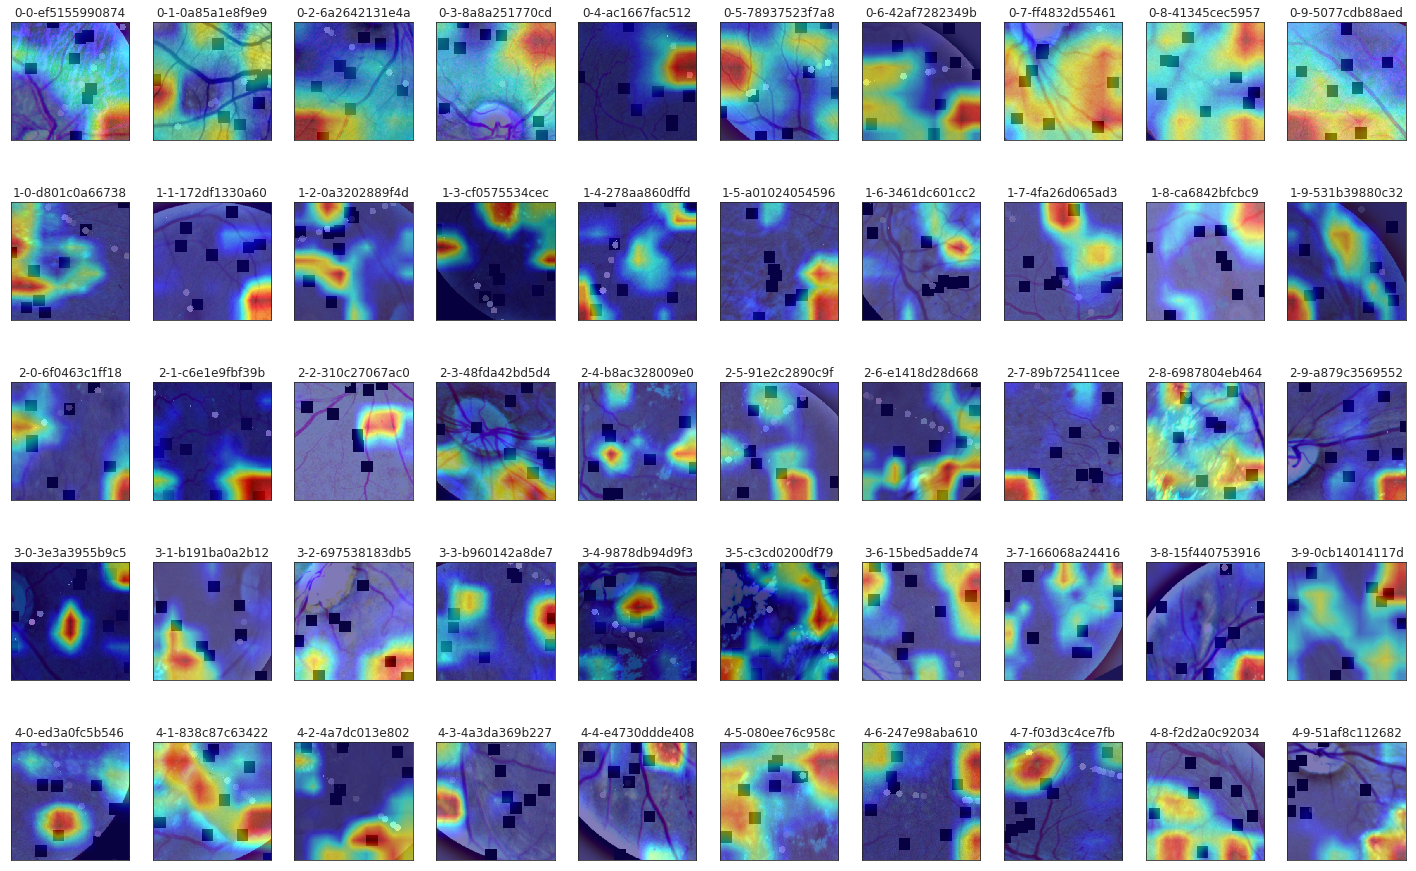

In [120]:
# DataLoaderを読みこんで可視化。
if __name__ == "__main__":
    from dataset import DATA_ROOT,TrainDataset, TTADataset, get_ids, N_CLASSES, load_transform_image, load_image
    import pandas as pd
    from transforms import train_transform, test_transform, tensor_transform
    
  #  N = 

    grad_cam = GradCam(model)
    
    root = DATA_ROOT / "train_images"
    df = pd.read_csv(DATA_ROOT / 'train.csv')
    
        # imageの可視化
    # circle cropあり
    NUM_SAMP=10
    SEED = 42
    fig = plt.figure(figsize=(25, 16))
    for class_id in sorted(np.unique(df.diagnosis)):
        df_class_id = df.loc[df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED)
        for i, idx in enumerate(np.arange(NUM_SAMP)):
#            Pdb().set_trace()
            item = df_class_id.iloc[idx]
            ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
         #   path=f"../input/aptos2019-blindness-detection/train_images/{['id_code']}.png"
           # image = load_ben_color(path,sigmaX=30)
           # Pdb().set_trace()
            image = load_image(item,root,img_size=600,circle=True,sigmaX=20)
            # Data Augmentation部分
            image = np.array(image)
          #  Pdb().set_trace()
          #  print(image.shape)
            
            data = {"image":image}
            image = train_transform(**data)
            image = image["image"]
            
            # GradCAMで特徴量の重要度を計算
          #  grad_cam = GradCam(model)
        
            image = tensor_transform(image).unsqueeze(dim=0)

            feature_image = grad_cam(image).squeeze(dim=0)
            feature_image = transforms.ToPILImage()(feature_image)

            pred_idx = model(image).max(1)[1]
            #print("pred: ", labels[int(pred_idx)])
          #  plt.title("Grad-CAM feature image")
          #  plt.imshow(feature_image.resize(image_size))
            
            plt.imshow(feature_image.resize((IMG_SIZE,IMG_SIZE)))
            ax.set_title('%d-%d-%s' % (class_id, idx, item.id_code))
            

In [113]:
a = tensor_transform(image).unsqueeze(dim=0)

In [114]:
a.shape

torch.Size([1, 3, 288, 288])

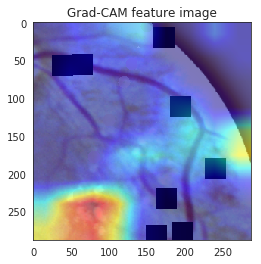

In [117]:
grad_cam = GradCam(model)

feature_image = grad_cam(a).squeeze(dim=0)
feature_image = transforms.ToPILImage()(feature_image)

pred_idx = model(a).max(1)[1]
#print("pred: ", labels[int(pred_idx)])
plt.title("Grad-CAM feature image")
plt.imshow(feature_image.resize(image_size))